##  4 class EEG Signal Classification 

#### Data
The dataset has 4 classes: Motor execution : move hands vs. move feet; Motor imagery : imagine motion of fist vs. imagine motion of feet. The data was taken from https://www.physionet.org/pn4/eegmmidb/ for subject 1 only, and downloaded via MNE Python.

####  Artifact detection & removal
Notch filter was used to filter out artifact/glitch occuring at 60 Hz 

####  Beta band extraction
Beta band (14 to 30 Hz) was extracted because in EEG signal classification, among different frequency bands, certain bands carry more distinguishing features

#### Dimentionality reduction 
The samples in the original data have dimensions (64, 961), which is reduced to 4 via Common Spatial Pattern (CSP)

In [5]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import matplotlib.pyplot as plt

from sklearn.pipeline import Pipeline

from sklearn.model_selection import ShuffleSplit, cross_val_score

from mne import Epochs, pick_types, find_events
from mne.channels import read_layout
from mne.io import concatenate_raws, read_raw_edf
from mne.datasets import eegbci
from mne.decoding import CSP

import mne
mne.set_log_level('CRITICAL')

In [2]:
def extract_data(runs, event_id):
    tmin, tmax = -1., 5.
    subject, runs = 1, runs

    raw_fnames = eegbci.load_data(subject, runs)
    raw_files = [read_raw_edf(f, preload=True, stim_channel='auto') for f in
                 raw_fnames]
    raw = concatenate_raws(raw_files)

    picks = pick_types(raw.info, meg=False, eeg=True, stim=False, eog=False,
                       exclude='bads')
    
    print("Notice the artifact at 60 Hz")
    raw.plot_psd(tmax=np.inf, fmax=250)

    #Apply notch filter
    raw.notch_filter(60, picks=picks, filter_length='auto',phase='zero')

    # Apply band-pass filter
    raw.filter(14., 30., fir_design='firwin', skip_by_annotation='edge')

    events = find_events(raw, shortest_event=0, stim_channel='STI 014')


    # Read epochs (train will be done only between 1 and 2s)
    # Testing will be done with a running classifier
    epochs = Epochs(raw, events, event_id, tmin, tmax, proj=True, picks=picks,
                    baseline=None, preload=True)
    
    # epochs_train = epochs.copy().crop(tmin=1., tmax=2.)
    epochs_ = epochs.copy()
    epochs_ = epochs_.get_data()
    
    if runs == runs3:
        labels = epochs.events[:, -1] -2
        event_id = dict(fist=2, feet=3)
    elif runs == runs4:
        labels = epochs.events[:, -1] 
        event_id = dict(imag_fist=2, imag_feet=3)
        
    return epochs_, labels, raw , picks

Task 3 consists of events:  ['move_both_fists', 'move_both_feet']
Task 3 data (42, 64, 961) and labels (42,)
Notice the artifact at 60 Hz


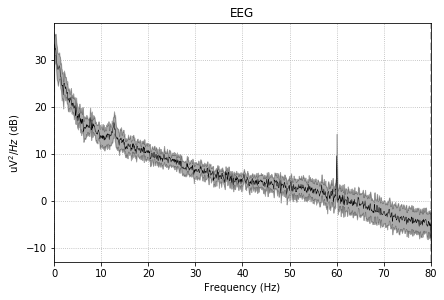

 
Task 4 consists of events:  ['imagine_moving_fists', 'imagine_moving_feet']
Task 4 data (42, 64, 961) and labels (42,)
Notice the artifact at 60 Hz


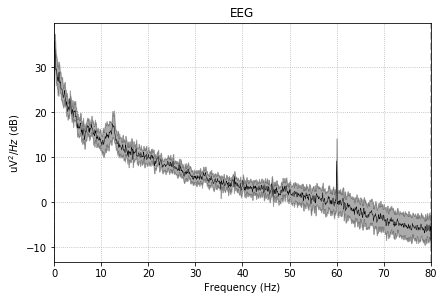

In [6]:
#**** TASK 3: MOVE FISTS vs. MOVE FEET
runs3 = [5,9,13]  #motor imagery: Task 3: execute fist vs. feet  

print("Task 3 consists of events: ", list(event_id3.keys()))
print("Task 3 data {} and labels {}".format(data3.shape, labels3.shape))

event_id3 = dict(move_both_fists=2, move_both_feet=3)     
data3, labels3, raw3, picks3 = extract_data(runs3, event_id3)
                     
print(" ")        

#TASK 4: IMAGINE MOVING FISTS vs. FEET

print("Task 4 consists of events: ", list(event_id4.keys()))
print("Task 4 data {} and labels {}".format(data4.shape, labels4.shape))

runs4 = [6,10,14]  #motor imagery: Task 2: imagine fist vs. feet
event_id4 = dict(imagine_moving_fists=2, imagine_moving_feet=3) 
data4, labels4, raw4, picks4 = extract_data(runs4, event_id4)

In [17]:
data = np.vstack((data3, data4))
labels = np.hstack((labels3, labels4))

print("Combine data from all tasks to form the final dataset")
print("Data {}, labels {} and classes {} present".format(data.shape, labels.shape, np.unique(labels)))

Combine data from all tasks to form the final dataset
Data (84, 64, 961), labels (84,) and classes [0 1 2 3] present


## SVC

In [24]:
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
X_train, X_test, y_train, y_test = train_test_split(data, labels, train_size = 0.8, random_state = 0)

print("Training data {}, labels {}".format(X_train.shape, y_train.shape))  
print("Test data shape {}, labels {}".format(X_test.shape,y_test.shape))  
print(" ")

svc = SVC()
csp = CSP(n_components=4, reg=None, log=True, norm_trace=False)

pipeline_svc = Pipeline([('CSP', csp), ('SVC', svc)])

from sklearn.metrics import classification_report, accuracy_score

pipeline_svc.fit(X_train, y_train)

y_pred = pipeline_svc.predict(X_test)

print('Test accuracy = {}'.format(accuracy_score(y_test, y_pred)))

print("Classification report:")
print(classification_report(y_test, y_pred))

Training data (67, 64, 961), labels (67,)
Test data shape (17, 64, 961), labels (17,)
 
Test accuracy = 0.7058823529411765
Classification report:
             precision    recall  f1-score   support

          0       0.67      0.50      0.57         4
          1       0.71      1.00      0.83         5
          2       0.80      0.67      0.73         6
          3       0.50      0.50      0.50         2

avg / total       0.71      0.71      0.70        17



## SVC, cross validation

In [30]:
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.svm import SVC

print("Training data {}, labels {}".format(X_train.shape, y_train.shape))  
print("Test data shape {}, labels {}".format(X_test.shape,y_test.shape))  
print(" ")

svc = SVC()
csp = CSP(n_components=4, reg=None, log=True, norm_trace=False)

pipeline_svc = Pipeline([('CSP', csp), ('SVC', svc)])

from sklearn.metrics import classification_report, accuracy_score

scores = cross_val_score(pipeline_svc, X_train, y_train, cv = 3)
print('Cross validated score = {}'.format(np.mean(scores)))
print("  ")

y_pred = cross_val_predict(pipeline_svc, X_test, y_test, cv = 3)
print("Test accuracy = {}".format(accuracy_score(y_test, y_pred)))
print("Classification report:")
print(classification_report(y_test, y_pred))

Training data (67, 64, 961), labels (67,)
Test data shape (17, 64, 961), labels (17,)
 
Cross validated score = 0.6998556998556998
  
Test accuracy = 0.5882352941176471
Classification report:
             precision    recall  f1-score   support

          0       0.75      0.75      0.75         4
          1       0.60      0.60      0.60         5
          2       0.57      0.67      0.62         6
          3       0.00      0.00      0.00         2

avg / total       0.55      0.59      0.57        17



## Optimize hyperparameters: SVC Randomized search

In [27]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import reciprocal, uniform
from time import time

svm_clf1 = SVC(kernel = "rbf", cache_size = 7000)
param_grid = {"gamma": reciprocal(0.001, 0.1), "C": uniform(1, 10)}
rand_search_cv = RandomizedSearchCV(svm_clf1, param_grid, n_iter = 10, verbose = 1)
#the search is cross-validated (default 3 fold)

csp = CSP(n_components=4, reg=None, log=True, norm_trace=False)

pipeline_svc_rand = Pipeline([('CSP', csp), ('SVC_randsearch', rand_search_cv)])

from sklearn.metrics import classification_report, accuracy_score

start = time()

pipeline_svc_rand.fit(X_train, y_train)

print("Randomized search took {} minutes".format((time() - start)/60.0))
print("Best estimator:")
print(rand_search_cv.best_estimator_)
print("  ")

y_pred = pipeline_svc_rand.predict(X_test)

print('Test accuracy = {}'.format(accuracy_score(y_test, y_pred)))

print("Classification report:")
print(classification_report(y_test, y_pred))

Fitting 3 folds for each of 10 candidates, totalling 30 fits
Randomized search took 0.2328125 minutes
Best estimator:
SVC(C=8.453008616822833, cache_size=7000, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.07486643408176219,
  kernel='rbf', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False)
  
Test accuracy = 0.7647058823529411
Classification report:
             precision    recall  f1-score   support

          0       0.67      0.50      0.57         4
          1       0.71      1.00      0.83         5
          2       0.83      0.83      0.83         6
          3       1.00      0.50      0.67         2

avg / total       0.78      0.76      0.75        17



[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:    0.1s finished


## Decision Tree- randomized search

In [33]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import reciprocal, uniform
from time import time

csp = CSP(n_components=4, reg=None, log=True, norm_trace=False)

tree = DecisionTreeClassifier()
param_grid = {'max_leaf_nodes': list(range(2, 40)), 'max_depth':[2, 3, 4], 'min_samples_split': [2, 3, 4]}

tree_rand_search = RandomizedSearchCV(tree, param_grid, n_iter = 10, verbose = 1)
#the search is cross-validated (default 3 fold)

pipeline_tree_rand = Pipeline([('CSP', csp), ('tree_randsearch', tree_rand_search)])

from sklearn.metrics import classification_report, accuracy_score

start = time()

pipeline_tree_rand.fit(X_train, y_train)

print("Randomized search took {} minutes".format((time() - start)/60.0))
print("Best estimator:")
print(tree_rand_search.best_estimator_)
print("  ")

y_pred = pipeline_tree_rand.predict(X_test)

print('Test accuracy = {}'.format(accuracy_score(y_test, y_pred)))

print("Classification report:")
print(classification_report(y_test, y_pred))

Fitting 3 folds for each of 10 candidates, totalling 30 fits
Randomized search took 0.17295485337575275 minutes
Best estimator:
DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=2,
            max_features=None, max_leaf_nodes=5, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best')
  
Test accuracy = 0.7058823529411765
Classification report:
             precision    recall  f1-score   support

          0       0.75      0.75      0.75         4
          1       1.00      0.80      0.89         5
          2       0.67      0.67      0.67         6
          3       0.33      0.50      0.40         2

avg / total       0.75      0.71      0.72        17



[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:    0.0s finished


## Random Forest- Randomized search

In [35]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import reciprocal, uniform
from time import time

csp = CSP(n_components=4, reg=None, log=True, norm_trace=False)

forest = RandomForestClassifier()
param_grid = {'max_leaf_nodes': list(range(2, 40)), 'max_depth':[2, 3, 4], 'min_samples_split': [2, 3, 4],
             'n_estimators': list(range(10, 40))}

forest_rand_search = RandomizedSearchCV(forest, param_grid, n_iter = 10, verbose = 1)
#the search is cross-validated (default 3 fold)

pipeline_forest_rand = Pipeline([('CSP', csp), ('forest_randsearch', forest_rand_search)])

from sklearn.metrics import classification_report, accuracy_score

start = time()

pipeline_forest_rand.fit(X_train, y_train)

print("Randomized search took {} minutes".format((time() - start)/60.0))
print("Best estimator:")
print(forest_rand_search.best_estimator_)
print("  ")

y_pred = pipeline_forest_rand.predict(X_test)

print('Test accuracy = {}'.format(accuracy_score(y_test, y_pred)))

print("Classification report:")
print(classification_report(y_test, y_pred))

Fitting 3 folds for each of 10 candidates, totalling 30 fits
Randomized search took 0.23843063910802206 minutes
Best estimator:
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=3, max_features='auto', max_leaf_nodes=21,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=3,
            min_weight_fraction_leaf=0.0, n_estimators=17, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)
  
Test accuracy = 0.8235294117647058
Classification report:
             precision    recall  f1-score   support

          0       0.80      1.00      0.89         4
          1       1.00      1.00      1.00         5
          2       0.80      0.67      0.73         6
          3       0.50      0.50      0.50         2

avg / total       0.82      0.82      0.82        17



[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:    2.9s finished


## XGBoost

In [39]:
import xgboost as xgb
from time import time

csp = CSP(n_components = 8, reg=None, log=False)

X_train_csp = csp.fit_transform(X_train, y_train)
X_test_csp = csp.transform(X_test)

dtrain = xgb.DMatrix(X_train_csp, label = y_train)
dtest = xgb.DMatrix(X_test_csp, label = y_test)

from sklearn import metrics

parameters = {'num_class': 4}  
iter_ = 200

xgb_class = xgb.train(parameters, dtrain, iter_)

from sklearn.metrics import classification_report, accuracy_score

start = time()

y_pred = xgb_class.predict(dtest)

print('Test accuracy = {}'.format(accuracy_score(y_test, y_pred)))

print("Classification report:")
print(classification_report(y_test, y_pred))

Test accuracy = 0.8823529411764706
Classification report:
             precision    recall  f1-score   support

          0       0.80      1.00      0.89         4
          1       1.00      1.00      1.00         5
          2       0.83      0.83      0.83         6
          3       1.00      0.50      0.67         2

avg / total       0.89      0.88      0.88        17



## XGBoost- Randomized search

In [48]:
import warnings
warnings.filterwarnings('ignore')

import xgboost as xgb
from time import time
from sklearn.model_selection import RandomizedSearchCV
from xgboost.sklearn import XGBClassifier

csp = CSP(n_components = 8, reg=None, log=False)

X_train_csp = csp.fit_transform(X_train, y_train)
X_test_csp = csp.transform(X_test)

from sklearn import metrics

param_grid1 = {'max_depth':list(range(3,10,2)), 'min_child_weight': list(range(1,6,2)), 
               'reg_alpha': [0, 0.003, 0.006, 0.009, 0.01, 0.03], 'reg_lambda': [0.9, 1, 2, 3], 
               'learning_rate': [1e-4, 0.1e-3, 1e-2, 1e-1, 0.2, 0.3]}
start = time()
xgb_rand_search1 = RandomizedSearchCV(estimator = XGBClassifier(num_class= 4, early_stopping_rounds=20), 
                       param_distributions = param_grid1, scoring='accuracy',n_jobs=4)


xgb_rand_search1.fit(X_train_csp, y_train)
print("Randomized search took {} minutes".format((time()-start)/60))
print(xgb_rand_search1.best_params_)

from sklearn.metrics import classification_report, accuracy_score
y_pred = xgb_rand_search1.predict(X_test_csp)
print("  ")
print('Test accuracy = {}'.format(accuracy_score(y_test, y_pred)))
print("Classification report:")
print(classification_report(y_test, y_pred))

Randomized search took 0.14342336257298788 minutes
{'reg_lambda': 0.9, 'reg_alpha': 0.03, 'min_child_weight': 5, 'max_depth': 9, 'learning_rate': 0.3}
  
Test accuracy = 0.8235294117647058
Classification report:
             precision    recall  f1-score   support

          0       0.75      0.75      0.75         4
          1       0.83      1.00      0.91         5
          2       0.83      0.83      0.83         6
          3       1.00      0.50      0.67         2

avg / total       0.83      0.82      0.82        17

